In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from ruamel.yaml.scalarfloat import ScalarFloat

In [2]:
# creating paths
path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-11-30' # 2
config_name = 'config_001_hollowXtCos14.yaml' # 'config_001_ebert10M.yaml'
model_name = 'model_74999.pt' #  'model_24999.pt'

#config_name = 'config_001_r07.yaml' 
#model_name = 'model_84999_hollowr07.pt' 
config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [19]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'ExactSampling' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.logit_type = 'Direct'
cfg.sampler.num_corrector_steps = 3
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 750
cfg.sampler.is_ordinal = True

#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

number of parameters:  13923971
ema state dict function


In [20]:
n_samples = 49
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples

750it [01:00, 12.40it/s]


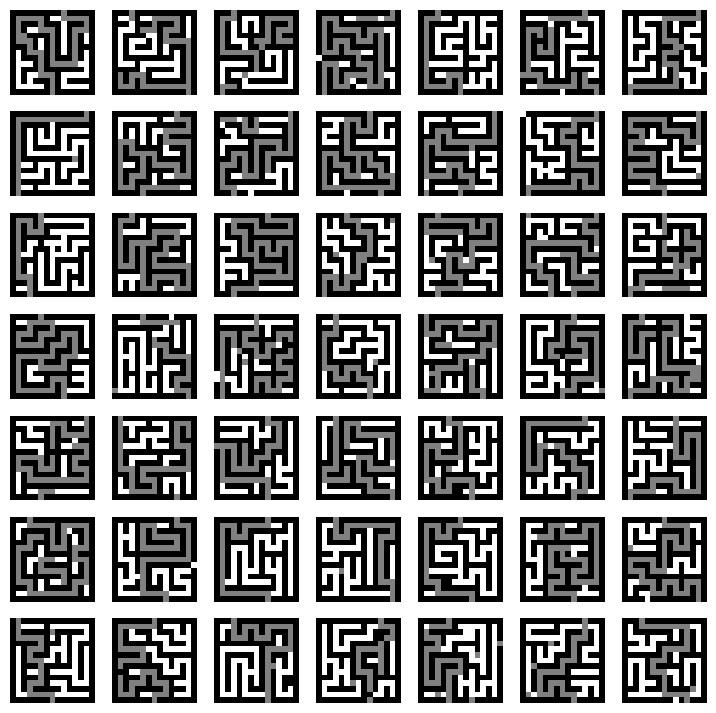

In [21]:
is_img = cfg.data.is_img

if is_img:
    samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
 
    plt.savefig(saving_train_path)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
 
    saving_plot_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")

[0.12598639726638794, 0.05696145072579384, 0.04770974814891815, 0.040725622326135635, 0.03510203957557678, 0.0319274365901947, 0.029931971803307533, 0.02757369540631771, 0.02521541900932789, 0.024943310767412186, 0.02321995422244072, 0.02421768754720688, 0.019682539626955986, 0.020680271089076996, 0.01913832128047943, 0.02004535123705864, 0.019682539626955986, 0.01886621303856373, 0.01913832128047943, 0.017777778208255768, 0.019591836258769035, 0.018231291323900223, 0.013424036093056202, 0.015147391706705093, 0.014693877659738064, 0.013605441898107529, 0.013605441898107529, 0.013514738529920578, 0.014603174291551113, 0.016326529905200005, 0.013514738529920578, 0.014149659313261509, 0.013333332724869251, 0.01541950087994337, 0.013151926919817924, 0.012335600331425667, 0.013605441898107529, 0.014603174291551113, 0.013605441898107529, 0.012426303699612617, 0.010975056327879429, 0.012426303699612617, 0.013424036093056202, 0.011791382916271687, 0.012879818677902222, 0.012517006136476994, 0.

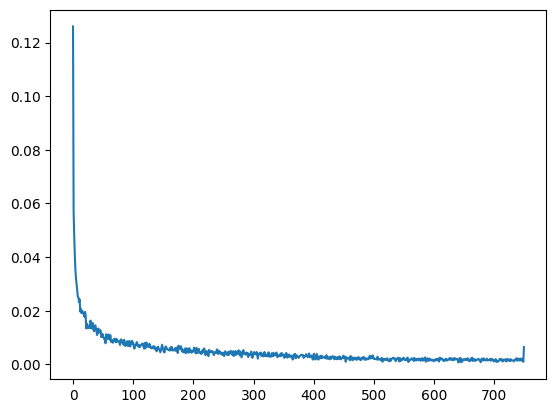

In [22]:
plt.plot(changes)
print(changes)
plt.show()